In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install imageio.v3
!pip install mplsoccer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Import statements
import os
import numpy as np
import pandas as pd
from matplotlib import animation, patches, pyplot as plt
from mplsoccer import Pitch

In [ ]:
# Constants
GAME_DURATION_SECONDS = 5646.24
START_TIME = 0
FRAME_INCREMENT = 5
PITCH_WIDTH = 68
PITCH_LENGTH = 105


# Function to load data
def load_data(link):
    df = pd.read_csv(link, skiprows=2)
    df.sort_values('Time [s]', inplace=True)
    return df

#TODO dl link
# Load data
link_away = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
             'data/Sample_Game_2/Sample_Game_2_RawTrackingData_Away_Team.csv')
link_home = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/'
             'data/Sample_Game_2/Sample_Game_2_RawTrackingData_Home_Team.csv')
link_event = ('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_2/Sample_Game_2_RawEventsData.csv')

df_away = load_data(link_away)
df_home = load_data(link_home)
df_event = pd.read_csv(link_event)

In [ ]:
print(df_home)

        Period   Frame  Time [s]  Player11  Unnamed: 4  Player1  Unnamed: 6  \
0            1       1      0.04   0.94275     0.50413  0.64812     0.28605   
1            1       2      0.08   0.94275     0.50413  0.64812     0.28605   
2            1       3      0.12   0.94275     0.50413  0.64812     0.28605   
3            1       4      0.16   0.94275     0.50413  0.64812     0.28605   
4            1       5      0.20   0.94275     0.50413  0.64812     0.28605   
...        ...     ...       ...       ...         ...      ...         ...   
141151       2  141152   5646.08   0.06285     0.51243  0.38499     0.15356   
141152       2  141153   5646.12   0.06285     0.51243  0.38499     0.15356   
141153       2  141154   5646.16   0.06285     0.51243  0.38499     0.15356   
141154       2  141155   5646.20   0.06285     0.51243  0.38499     0.15356   
141155       2  141156   5646.24   0.06285     0.51243  0.38499     0.15356   

        Player2  Unnamed: 8  Player3  ...  Player10

In [ ]:
# Reset column names
def set_col_names(df):
    """Renames the columns to have x and y suffixes."""
    cols = list(np.repeat(df.columns[3::2], 2))
    cols = [col+'_x' if i % 2 == 0 else col+'_y' for i, col in enumerate(cols)]
    cols = np.concatenate([df.columns[:3], cols])
    df.columns = cols

set_col_names(df_away)
set_col_names(df_home)


In [ ]:
# Subset data
end_time = START_TIME + GAME_DURATION_SECONDS
df_away = df_away[(df_away['Time [s]'] >= START_TIME) & (df_away['Time [s]'] < end_time)].copy()
df_home = df_home[(df_home['Time [s]'] >= START_TIME) & (df_home['Time [s]'] < end_time)].copy()


s### Preprocessing

In [ ]:
# Split off ball data (same for home and away)
df_ball = df_away[['Period', 'Frame', 'Time [s]', 'Ball_x', 'Ball_y']].copy()
df_home.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_away.drop(['Ball_x', 'Ball_y'], axis=1, inplace=True)
df_ball.rename({'Ball_x': 'x', 'Ball_y': 'y'}, axis=1, inplace=True)

In [ ]:
# Convert to long form
def to_long_form(df):
    """Pivots a dataframe from wide-form to long form."""
    df = pd.melt(df, id_vars=df.columns[:3], value_vars=df.columns[3:], var_name='player')
    df.loc[df.player.str.contains('_x'), 'coordinate'] = 'x'
    df.loc[df.player.str.contains('_y'), 'coordinate'] = 'y'
    df = df.dropna(axis=0, how='any')
    df['player'] = df.player.str[6:-2]
    df = (df.set_index(['Period', 'Frame', 'Time [s]', 'player', 'coordinate'])['value']
          .unstack()
          .reset_index()
          .rename_axis(None, axis=1))
    return df

df_away = to_long_form(df_away)
df_home = to_long_form(df_home)

In [ ]:
print(df_away[df_away['Frame'] == 2309])

       Period  Frame  Time [s] player        x        y
25388       1   2309     92.36     15  0.92082  0.42753
25389       1   2309     92.36     16  0.94911  0.50644
25390       1   2309     92.36     17  0.94821  0.59717
25391       1   2309     92.36     18  0.87140  0.20518
25392       1   2309     92.36     19  0.93611  0.56243
25393       1   2309     92.36     20  0.94185  0.53475
25394       1   2309     92.36     21  0.92447  0.50471
25395       1   2309     92.36     22  0.92321  0.47475
25396       1   2309     92.36     23  0.77988  0.55352
25397       1   2309     92.36     24  0.79944  0.20787
25398       1   2309     92.36     25  0.99414  0.50948


In [ ]:
# Get xT grid from Karun Singh's original 2017-2018 Premier League transition matrix.
# https://karun.in/blog/data/open_xt_12x8_v1.json

#home_offense_grid = pd.read_json('/content/drive/MyDrive/Colab Notebooks/TER/xt_grid_pl17:18.json')
home_offense_grid = pd.read_json('/content/drive/MyDrive/Master 1/Projet TER/Data/open_xt_12x8_v1.json')


In [ ]:
# Filter df_event to only keep pass events
pass_events_df = df_event[df_event['Type'] == 'PASS']


def is_home_on_home_side_at_kick_off():
  '''Returns true if the Home team starts in the home side (i.e. x < 0.5)'''
  return np.mean(df_home['x'][0]) < 0.5

def define_pass_type():
    # Setting offensive pass type conditions considering Home team being on the Home side by default.
    conditions = (
        ((pass_events_df['Team'] == 'Home') & (pass_events_df['Period'] == 1) & (pass_events_df['Start X'] >= 0.5) & (pass_events_df['End X'] >= 0.5)) |
        ((pass_events_df['Team'] == 'Home') & (pass_events_df['Period'] == 2) & (pass_events_df['Start X'] <= 0.5) & (pass_events_df['End X'] <= 0.5)) |
        ((pass_events_df['Team'] == 'Away') & (pass_events_df['Period'] == 1) & (pass_events_df['Start X'] <= 0.5) & (pass_events_df['End X'] <= 0.5)) |
        ((pass_events_df['Team'] == 'Away') & (pass_events_df['Period'] == 2) & (pass_events_df['Start X'] >= 0.5) & (pass_events_df['End X'] >= 0.5))
    )

    # Inverse the conditions if the Home team starts on the Away side.
    if not is_home_on_home_side_at_kick_off():
        conditions = ~conditions

    # Overwrite the current event Subtype with the pass type as we have no use for it.
    pass_types = np.where(conditions, "OFFENSIVE", "DEFENSIVE")
    pass_events_df.loc[:, "Subtype"] = pass_types


define_pass_type()


 ### Removing non offensive passes and keeping events that are at least 15 frames long.

In [ ]:
# FRAME_INCREMENT = 3
FRAME_INCREMENT = 1
SEQUENCE_DURATION = 15
EVENT_DURATION = SEQUENCE_DURATION * FRAME_INCREMENT

# Keeping offensive passes with event duration > 45 frames.
offensive_passes_df = pass_events_df.loc[
    (pass_events_df['Subtype'] == 'OFFENSIVE') &
    (pass_events_df['End Frame'] - pass_events_df['Start Frame'] >= EVENT_DURATION)
]

print(len(offensive_passes_df))

print(offensive_passes_df)


298
      Team  Type    Subtype  Period  Start Frame  Start Time [s]  End Frame  \
4     Away  PASS  OFFENSIVE       1           77            3.08         96   
5     Away  PASS  OFFENSIVE       1          191            7.64        217   
6     Away  PASS  OFFENSIVE       1          279           11.16        303   
16    Home  PASS  OFFENSIVE       1          536           21.44        556   
22    Away  PASS  OFFENSIVE       1          976           39.04       1010   
...    ...   ...        ...     ...          ...             ...        ...   
1668  Away  PASS  OFFENSIVE       2       136381         5455.24     136413   
1708  Away  PASS  OFFENSIVE       2       139898         5595.92     139943   
1720  Away  PASS  OFFENSIVE       2       141185         5647.40     141230   
1722  Away  PASS  OFFENSIVE       2       141436         5657.44     141451   
1741  Home  PASS  OFFENSIVE       2       143578         5743.12     143593   

      End Time [s]      From        To  Start X

### Formatting the bin to only get offense coordinates for xT computation

In [ ]:
print(df_ball)

        Period   Frame  Time [s]        x        y
0            1       1      0.04  0.45472  0.38709
1            1       2      0.08  0.49645  0.40656
2            1       3      0.12  0.53716  0.42556
3            1       4      0.16  0.55346  0.42231
4            1       5      0.20  0.55512  0.40570
...        ...     ...       ...      ...      ...
143624       2  143625   5745.00  0.04211  0.74253
143625       2  143626   5745.04  0.03980  0.79348
143626       2  143627   5745.08  0.03749  0.84442
143627       2  143628   5745.12  0.03519  0.89537
143628       2  143629   5745.16  0.03288  0.94632

[143629 rows x 5 columns]


In [ ]:
# Merge df_ball with offensive_passes_df based on 'start_frame' matching 'Frame'
merged_df_start = pd.merge(df_ball, offensive_passes_df,
                            left_on='Frame', right_on='Start Frame',
                            how='left')

# Merge df_ball with offensive_passes_df based on 'end_frame' matching 'Frame'
merged_df_end = pd.merge(df_ball, offensive_passes_df,
                          left_on='Frame', right_on='End Frame',
                          how='left')

df_ball_team = df_ball.copy()

# Combine the 'Team' values from both merges using where condition
df_ball_team['Team'] = merged_df_start['Team'].combine_first(merged_df_end['Team'])

#
for _, event in offensive_passes_df.iterrows():
    start_frame = event['Start Frame']
    for frame in range(event['Start Frame'] + 1, event['End Frame']):
        df_ball_team.loc[df_ball_team['Frame'] == frame, 'Team'] = event['Team']

# Filter df_ball to keep only rows that have a valid 'Team' value
df_ball_team = df_ball_team.dropna(subset=['Team'])

# Reset index of df_ball after filtering
df_ball_team.reset_index(drop=True, inplace=True)

# Display df_ball with updated 'Team' values
print(df_ball_team[df_ball_team['Frame'] == 10551])

     Period  Frame  Time [s]        x        y  Team
626       1  10551    422.04  0.78949  0.36116  Home


In [ ]:
xT_rows, xT_cols = home_offense_grid.shape
df_ball_team['x_bin'] = pd.cut(df_ball_team['x'], bins=xT_cols, labels=False)
df_ball_team['y_bin'] = pd.cut(df_ball_team['y'], bins=xT_rows, labels=False)

# Adjust bin indices for symmetry
grid_half_x_index = (xT_cols // 2) - 1

df_ball_team['x_bin_sym'] = df_ball_team['x_bin'].apply(lambda bin_index:
                                              bin_index if bin_index > grid_half_x_index
                                              else (xT_cols - 1) - bin_index)


In [ ]:
print(df_ball_team)

      Period   Frame  Time [s]        x        y  Team  x_bin  y_bin  \
0          1    7203    288.12  0.13204  0.01860  Away      1      0   
1          1    7204    288.16  0.14000  0.02000  Away      1      0   
2          1    7205    288.20  0.13539  0.01392  Away      1      0   
3          1    7206    288.24  0.13643  0.01552  Away      1      0   
4          1    7207    288.28  0.13744  0.01707  Away      1      0   
...      ...     ...       ...      ...      ...   ...    ...    ...   
3879       2  141226   5649.04  0.76139  0.09822  Away      8      0   
3880       2  141227   5649.08  0.76399  0.09031  Away      9      0   
3881       2  141228   5649.12  0.76659  0.08241  Away      9      0   
3882       2  141229   5649.16  0.76919  0.07450  Away      9      0   
3883       2  141230   5649.20  0.77179  0.06660  Away      9      0   

      x_bin_sym  
0            10  
1            10  
2            10  
3            10  
4            10  
...         ...  
3879     

### Set up frames by increment of 15 => 6093


In [ ]:
frames = set()
sequences = []

"""
# Iterate over each event
for index, event in offensive_passes_df.iterrows():
  for frame in range(event['Start Frame'], event['End Frame'] - 44, 10):
    sequences.append(list(range(frame, frame + 45, 3)))
    frames.update(range(frame, frame + 45, 3))
print(len(sequences))
"""
SEQUENCE_DURATION = 15

for _, event in offensive_passes_df.iterrows():
    linear_range = np.linspace(event['Start Frame'], event['End Frame'], SEQUENCE_DURATION, dtype=int)
    sequences.append(list(linear_range))
    frames.update(linear_range)


In [ ]:
print(sequences)
print(frames)

[[77, 78, 79, 81, 82, 83, 85, 86, 87, 89, 90, 91, 93, 94, 96], [191, 192, 194, 196, 198, 200, 202, 204, 205, 207, 209, 211, 213, 215, 217], [279, 280, 282, 284, 285, 287, 289, 291, 292, 294, 296, 297, 299, 301, 303], [536, 537, 538, 540, 541, 543, 544, 546, 547, 548, 550, 551, 553, 554, 556], [976, 978, 980, 983, 985, 988, 990, 993, 995, 997, 1000, 1002, 1005, 1007, 1010], [2143, 2145, 2148, 2151, 2154, 2157, 2160, 2163, 2166, 2169, 2172, 2175, 2178, 2181, 2184], [2263, 2264, 2266, 2268, 2270, 2272, 2274, 2276, 2277, 2279, 2281, 2283, 2285, 2287, 2289], [7203, 7207, 7212, 7216, 7221, 7225, 7230, 7234, 7239, 7243, 7248, 7252, 7257, 7261, 7266], [7266, 7267, 7269, 7271, 7272, 7274, 7276, 7278, 7279, 7281, 7283, 7284, 7286, 7288, 7290], [7334, 7337, 7341, 7345, 7349, 7352, 7356, 7360, 7364, 7368, 7371, 7375, 7379, 7383, 7387], [7404, 7405, 7407, 7408, 7410, 7412, 7413, 7415, 7417, 7418, 7420, 7422, 7423, 7425, 7427], [7519, 7521, 7524, 7526, 7529, 7532, 7534, 7537, 7540, 7542, 7545, 7548,

## xT computation

In [ ]:
def get_xT_evolution(start_frame, end_frame):

    ball_at_start_frame = df_ball_team[(df_ball_team['Frame'] == start_frame)]
    ball_at_end_frame = df_ball_team[(df_ball_team['Frame'] == end_frame)]

    # Extract the 'x_bin_sym' values from the filtered DataFrame
    xT_start = home_offense_grid[ball_at_start_frame['x_bin_sym'].iloc[0].astype(int)][ball_at_start_frame['y_bin'].iloc[0].astype(int)]
    xT_end = home_offense_grid[ball_at_end_frame['x_bin_sym'].iloc[0].astype(int)][ball_at_end_frame['y_bin'].iloc[0].astype(int)]

    return xT_end - xT_start


In [ ]:
xT = []

for sequence in sequences:
    xT.append(get_xT_evolution(start_frame=sequence[0], end_frame=sequence[-1]))


In [ ]:
print(xT)
print(len(xT))
neg_xT = [value for value in xT if value < 0]
print(len(neg_xT))
print(len(xT) - len(neg_xT))
#print(sorted(xT, reverse=True))


[3.931999999999894e-05, 0.0018699699999999986, -0.002714639999999999, -3.931999999999894e-05, -0.0013324699999999988, -0.003075179999999997, 0.0673811, -0.005318, 0.005318, -0.01011252, 0.012082120000000002, -0.007330730000000001, 0.0029011099999999984, -0.010362779999999999, -0.012117899999999997, 0.20254223999999998, 0.0, -0.003075179999999997, -0.006298700000000001, -0.004429620000000002, 0.0, 0.003075419999999999, 0.0012505900000000028, 0.003075179999999997, -0.010362779999999999, 0.013106799999999998, 0.002714639999999999, 0.0021199999999999986, -0.0021199999999999986, 0.004365330000000001, 0.07012512, 0.1494026, 0.0013821700000000003, 0.0007771499999999973, 0.00722712, 0.08392862, -0.0012528699999999997, 0.0, 0.0025853399999999985, -0.0006478500000000019, 0.0006193799999999958, -0.0002709099999999992, 0.0, -0.0025853399999999985, 0.004365330000000001, -0.0034407200000000013, 0.010990860000000002, -0.010990860000000002, 0.0, 0.0002709099999999992, 0.00722712, -0.000270909999999999

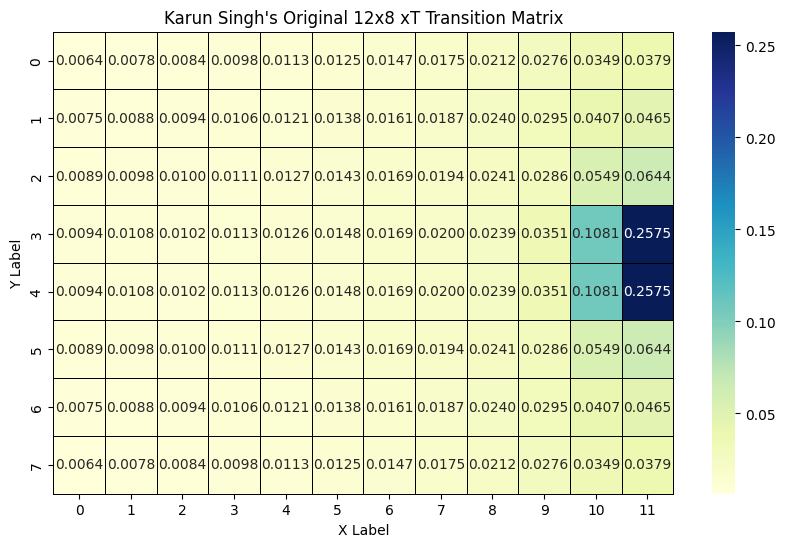

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.heatmap(home_offense_grid, annot=True, fmt=".4f", cmap="YlGnBu", linewidths=.5, linecolor='black', clip_on=False)
plt.xlabel("X Label")
plt.ylabel("Y Label")
plt.title("Karun Singh's Original 12x8 xT Transition Matrix")
plt.show()

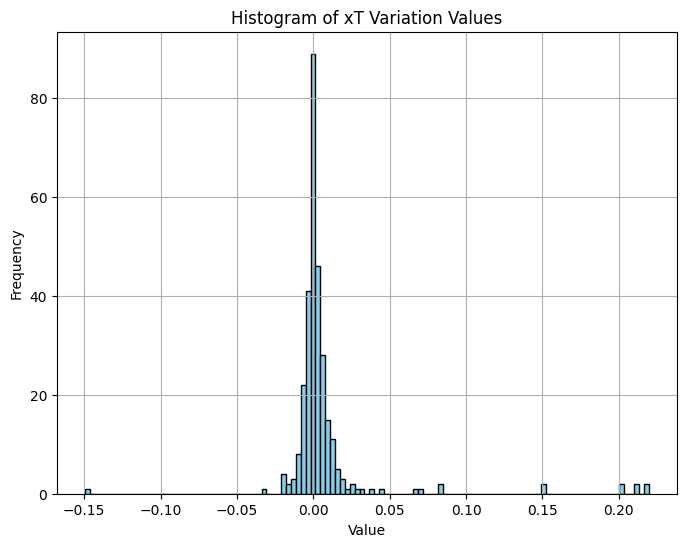

In [ ]:
df_xT = pd.DataFrame(xT)

df_xT.describe()

import matplotlib.pyplot as plt

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(df_xT.values.flatten(), 115,color='skyblue', edgecolor='black')
plt.title('Histogram of xT Variation Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [ ]:
positive_xT_indexes = df_xT[df_xT[0] > 0].index

# Initialize lists to store new rows
new_rows_home = []
new_rows_away = []


# Process each sequence found
max_index = len(df_home)
for index in positive_xT_indexes:
    new_sequence = []
    for frame in sequences[index]:
        # Update Home rows
        home_rows = df_home[df_home['Frame'] == frame].copy()
        home_rows['y'] = 1 - home_rows['y']
        home_rows['Frame'] = max_index
        home_rows['Changed'] = True
        new_rows_home.append(home_rows)

        # Update away rows
        away_rows = df_away[df_away['Frame'] == frame].copy()
        away_rows['y'] = 1 - away_rows['y']
        away_rows['Frame'] = max_index
        away_rows['Changed'] = True
        new_rows_away.append(away_rows)

        new_sequence.append(max_index)
        max_index += 1

    # Append the updated sequence
    sequences.append(new_sequence)

# Concatenate new rows and update original DataFrames
df_home_new_rows = pd.concat([df_home] + new_rows_home, ignore_index=True)
df_away_new_rows = pd.concat([df_away] + new_rows_away, ignore_index=True)

# Display the updated DataFrames
print("Updated df_home:")
print(df_home_new_rows)
print("\nUpdated df_away:")
print(df_away_new_rows)

Updated df_home:
         Period    Frame  Time [s] player        x        y Changed
0             1        1      0.04      1  0.32648  0.65322     NaN
1             1        1      0.04     10  0.55243  0.43269     NaN
2             1        1      0.04     11  0.00082  0.48238     NaN
3             1        1      0.04      2  0.33701  0.48863     NaN
4             1        1      0.04      3  0.30927  0.35529     NaN
...         ...      ...       ...    ...      ...      ...     ...
1586847       2  1580551   5649.20      4  0.84532  0.34930    True
1586848       2  1580551   5649.20      5  0.75992  0.53990    True
1586849       2  1580551   5649.20      7  0.83599  0.75724    True
1586850       2  1580551   5649.20      8  0.74962  0.39586    True
1586851       2  1580551   5649.20      9  0.68440  0.59261    True

[1586852 rows x 7 columns]

Updated df_away:
         Period    Frame  Time [s] player        x        y Changed
0             1        1      0.04     15  0.58393  0

In [ ]:
positive_xT_indexes = df_xT[df_xT[0] > 0].index

# Initialize max_index
max_index = len(df_home)

# Initialize empty lists to store dictionaries for new rows for both df_home and df_away
new_rows_home = []
new_rows_away = []

# Iterate over positive_xT_indexes
for index in positive_xT_indexes:
    new_sequence = []
    # Iterate over frames in sequences
    for frame in sequences[index]:
        # Create dictionary for new row in df_home
        new_row_home = {
            'Frame': max_index,
            'y': 1 - df_home.loc[df_home['Frame'] == frame, 'y'].values[0],
            'Changed': True
        }
        new_rows_home.append(new_row_home)

        # Create dictionary for new row in df_away
        new_row_away = {
            'Frame': max_index,
            'y': 1 - df_away.loc[df_away['Frame'] == frame, 'y'].values[0],
            'Changed': True
        }
        new_rows_away.append(new_row_away)

        new_sequence.append(max_index)
        max_index += 1
    sequences.append(new_sequence)

# Concatenate new rows to df_home
df_home_new_rows = pd.concat([df_home] + [pd.DataFrame(new_rows_home)], ignore_index=True)
# Concatenate new rows to df_away
df_away_new_rows = pd.concat([df_away] + [pd.DataFrame(new_rows_away)], ignore_index=True)


In [ ]:
print(df_home)
print(df_home_new_rows[-50:])
print(len(df_home_new_rows) - len(df_home))

         Period   Frame  Time [s] player        x        y
0             1       1      0.04      1  0.32648  0.65322
1             1       1      0.04     10  0.55243  0.43269
2             1       1      0.04     11  0.00082  0.48238
3             1       1      0.04      2  0.33701  0.48863
4             1       1      0.04      3  0.30927  0.35529
...         ...     ...       ...    ...      ...      ...
1579917       2  143629   5745.16      4  0.10139  0.66310
1579918       2  143629   5745.16      5  0.05380  0.52328
1579919       2  143629   5745.16      7  0.46487  0.28633
1579920       2  143629   5745.16      8  0.10964  0.54817
1579921       2  143629   5745.16      9  0.11614  0.45851

[1579922 rows x 6 columns]
         Period    Frame  Time [s] player        x        y Changed
1586802       2  1580547   5648.68      3  0.83284  0.45935    True
1586803       2  1580547   5648.68      4  0.84061  0.34566    True
1586804       2  1580547   5648.68      5  0.74706  0.53999 

In [ ]:
print(df_ball)

     Period   Frame  Time [s]        x        y  Team  x_bin  y_bin  x_bin_sym
0         1    7203    288.12  0.86796  0.01860  Away      1      0         10
1         1    7266    290.64  0.80262  0.10878  Away      2      1          9
2         1    7334    293.36  0.75904  0.01854  Away      2      0          9
3         1    7387    295.48  0.61757  0.07705  Away      4      0          7
4         1   10551    422.04  0.78949  0.36116  Home      9      3          9
..      ...     ...       ...      ...      ...   ...    ...    ...        ...
117       2  135822   5432.88  0.72178  0.81142  Home      3      6          8
118       2  139898   5595.92  0.56578  0.24704  Away      6      2          6
119       2  139943   5597.72  0.70470  0.17936  Away      8      1          8
120       2  141185   5647.40  0.65576  0.41837  Away      7      3          7
121       2  141230   5649.20  0.77179  0.06660  Away      9      0          9

[122 rows x 9 columns]


## Format to half court

In [ ]:
home_team_starts = is_home_on_home_side_at_kick_off()

df_ball_team_new_coordinates = df_ball_team.copy()
df_home_new_coordinates = df_home.copy()
df_away_new_coordinates = df_away.copy()

for index, event in df_ball_team.iterrows():

    conditions = (
        ((event['Period'] == 1) & (event['Team'] == 'Away')) |
        ((event['Period'] == 2) & (event['Team'] == 'Home'))
        )

    if not home_team_starts:
        conditions = ~conditions

    if conditions:
        df_ball_team_new_coordinates.loc[df_ball_team_new_coordinates['Frame'] == event['Frame'], 'x'] = 1 - df_ball_team.loc[df_ball_team['Frame'] == event['Frame'], 'x']
        df_home_new_coordinates.loc[df_home_new_coordinates['Frame'] == event['Frame'], 'x'] = 1 - df_home.loc[df_home['Frame'] == event['Frame'], 'x']
        df_away_new_coordinates.loc[df_away_new_coordinates['Frame'] == event['Frame'], 'x'] = 1 - df_away.loc[df_away['Frame'] == event['Frame'], 'x']



In [ ]:
print(df_ball_team[df_ball_team['Frame'] == 7266])
print(df_ball_team_new_coordinates[df_ball_team_new_coordinates['Frame'] == 7266])
print(df_away[df_away['Frame'] == 7266])
print(df_away_new_coordinates[df_away_new_coordinates['Frame'] == 7266])
print(df_home[df_home['Frame'] == 7266])
print(df_home_new_coordinates[df_home_new_coordinates['Frame'] == 7266])

    Period  Frame  Time [s]        x        y  Team  x_bin  y_bin  x_bin_sym
63       1   7266    290.64  0.19738  0.10878  Away      2      1          9
    Period  Frame  Time [s]        x        y  Team  x_bin  y_bin  x_bin_sym
63       1   7266    290.64  0.80262  0.10878  Away      2      1          9
       Period  Frame  Time [s] player        x        y
79915       1   7266    290.64     15  0.44429  0.16966
79916       1   7266    290.64     16  0.47383  0.29872
79917       1   7266    290.64     17  0.46229  0.50299
79918       1   7266    290.64     18  0.17319  0.04539
79919       1   7266    290.64     19  0.30460  0.14244
79920       1   7266    290.64     20  0.35095  0.28530
79921       1   7266    290.64     21  0.19794  0.10964
79922       1   7266    290.64     22  0.33892  0.68828
79923       1   7266    290.64     23  0.18014  0.37688
79924       1   7266    290.64     24  0.14466  0.36258
79925       1   7266    290.64     25  0.78815  0.46703
       Period  Frame

In [ ]:
test = df_away[df_away.Frame == frame]
print(test)

         Period   Frame  Time [s] player        x        y
1579504       2  143592   5743.68     15  0.08342  0.78275
1579505       2  143592   5743.68     16  0.08208  0.57302
1579506       2  143592   5743.68     17  0.20320  0.69886
1579507       2  143592   5743.68     18  0.42852  0.43671
1579508       2  143592   5743.68     20  0.12425  0.47129
1579509       2  143592   5743.68     21  0.13746  0.60268
1579510       2  143592   5743.68     23  0.46958  0.47538
1579511       2  143592   5743.68     25  0.00450  0.52389
1579512       2  143592   5743.68     26  0.34701  0.55498
1579513       2  143592   5743.68     27  0.37804  0.32331
1579514       2  143592   5743.68     28  0.13731  0.47278


### Save frame

In [ ]:
# Define a directory to save the figures
output_directory = "/content/drive/MyDrive/Master 1/Projet TER/Images/Metrica Sports/Game 1/Half Pitch - xT"

# Create the directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

filenames = []

p = Pitch(pitch_type='metricasports', goal_type='line', half=True,
          pitch_width=PITCH_WIDTH, pitch_length=PITCH_LENGTH,
          pad_left=None, pad_right=None, pad_bottom=None, pad_top=None,
          line_color=None, goal_alpha=0, line_alpha=0)

for sequence in sequences:
    for frame in sequence:
        # Create file name and append it to a list
        filename = os.path.join(output_directory, f'voronoi_xT_{frame}.png')

        # Check if the frame image does not already exist
        if not os.path.isfile(filename):
            #filenames.append(filename)

            fig, ax = p.draw()
            # ball_coordinates = df_ball[df_ball.Frame == frame]
            away_coordinates = df_away_new_coordinates[df_away_new_coordinates.Frame == frame]
            home_coordinates = df_home_new_coordinates[df_home_new_coordinates.Frame == frame]
            player_coordinates = pd.concat([away_coordinates, home_coordinates])
            # Plot Voronoi
            team1, team2 = p.voronoi(player_coordinates.x, player_coordinates.y,
                                    [0]*11 + [1]*11)

            t1 = p.polygon(team1, ax=ax, fc='orange', ec='black', lw=0, alpha=1)
            t2 = p.polygon(team2, ax=ax, fc='dodgerblue', ec='black', lw=0, alpha=1)
            # Plot players
            #sc1 = p.scatter(away_coordinates.x, away_coordinates.y, c='dodgerblue', s=80, ec='k', ax=ax)
            #sc2 = p.scatter(home_coordinates.x, home_coordinates.y, c='orange', s=80, ec='k', ax=ax)

            # Plot ball
            #sc3 = p.scatter(ball_coordinates.x, ball_coordinates.y, c='white', s=30, ec='k', ax=ax)



            # Save frame
            plt.savefig(filename, bbox_inches='tight', pad_inches=0)
            plt.close()



In [ ]:
import json
from google.colab import files

In [ ]:
# Convert into JSON
# File name is mydata.json
with open("xT_new.json", "w") as final:
    json.dump(xT, final)

In [ ]:
# Download the file
files.download('xT_new.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>